# <div style="text-align:center; border-radius:25px; padding:20px; color:#3B1AE1; font-size:100%; font-family:cursive; border: 2px solid #00a1d6; overflow: hidden;"><b>🚀 Import Required Libraries</b></div>

In [1]:
import os
import random
import shutil
import numpy as np
import pandas as pd
import itertools

# Visualization Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Image processing libraries
import cv2
from PIL import Image

# Model and evaluation libraries
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.applications import VGG19, DenseNet121, MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Ignore the warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# <div style="text-align:center; border-radius:25px; padding:20px; color:#3B1AE1; font-size:100%; font-family:cursive; border: 2px solid #00a1d6; overflow: hidden;"><b>🚀 Data Preparation</b></div>

Dataset berasal dari [kaggle](https://www.kaggle.com/datasets/alessiocorrado99/animals10) dan pelatihannya juga menggunakan notebook pada [kaggle](https://www.kaggle.com/code/lutfikurrotaeni/animals-image-classification-val-acc-95/notebook)

In [2]:
dataset_path = '../input/animals10/raw-img'
classes = []

for folder in os.listdir(dataset_path):
    classes.append(folder)
    
print(classes)

['cavallo', 'pecora', 'elefante', 'gatto', 'scoiattolo', 'gallina', 'ragno', 'mucca', 'cane', 'farfalla']


In [3]:
print('Number of images in each class:')
for folder in classes:
    data_path = os.path.join(dataset_path, folder)
    if os.path.isdir(data_path):
        data_list = os.listdir(data_path)
        count = 0
        for file in data_list:
            count += 1
    print(f'{folder}: {count}')

Number of images in each class:
cavallo: 2623
pecora: 1820
elefante: 1446
gatto: 1668
scoiattolo: 1862
gallina: 3098
ragno: 4821
mucca: 1866
cane: 4863
farfalla: 2112


In [4]:
lung_image = {}

for i in os.listdir(dataset_path):
    lung_image[i] = os.listdir(os.path.join(dataset_path, i))

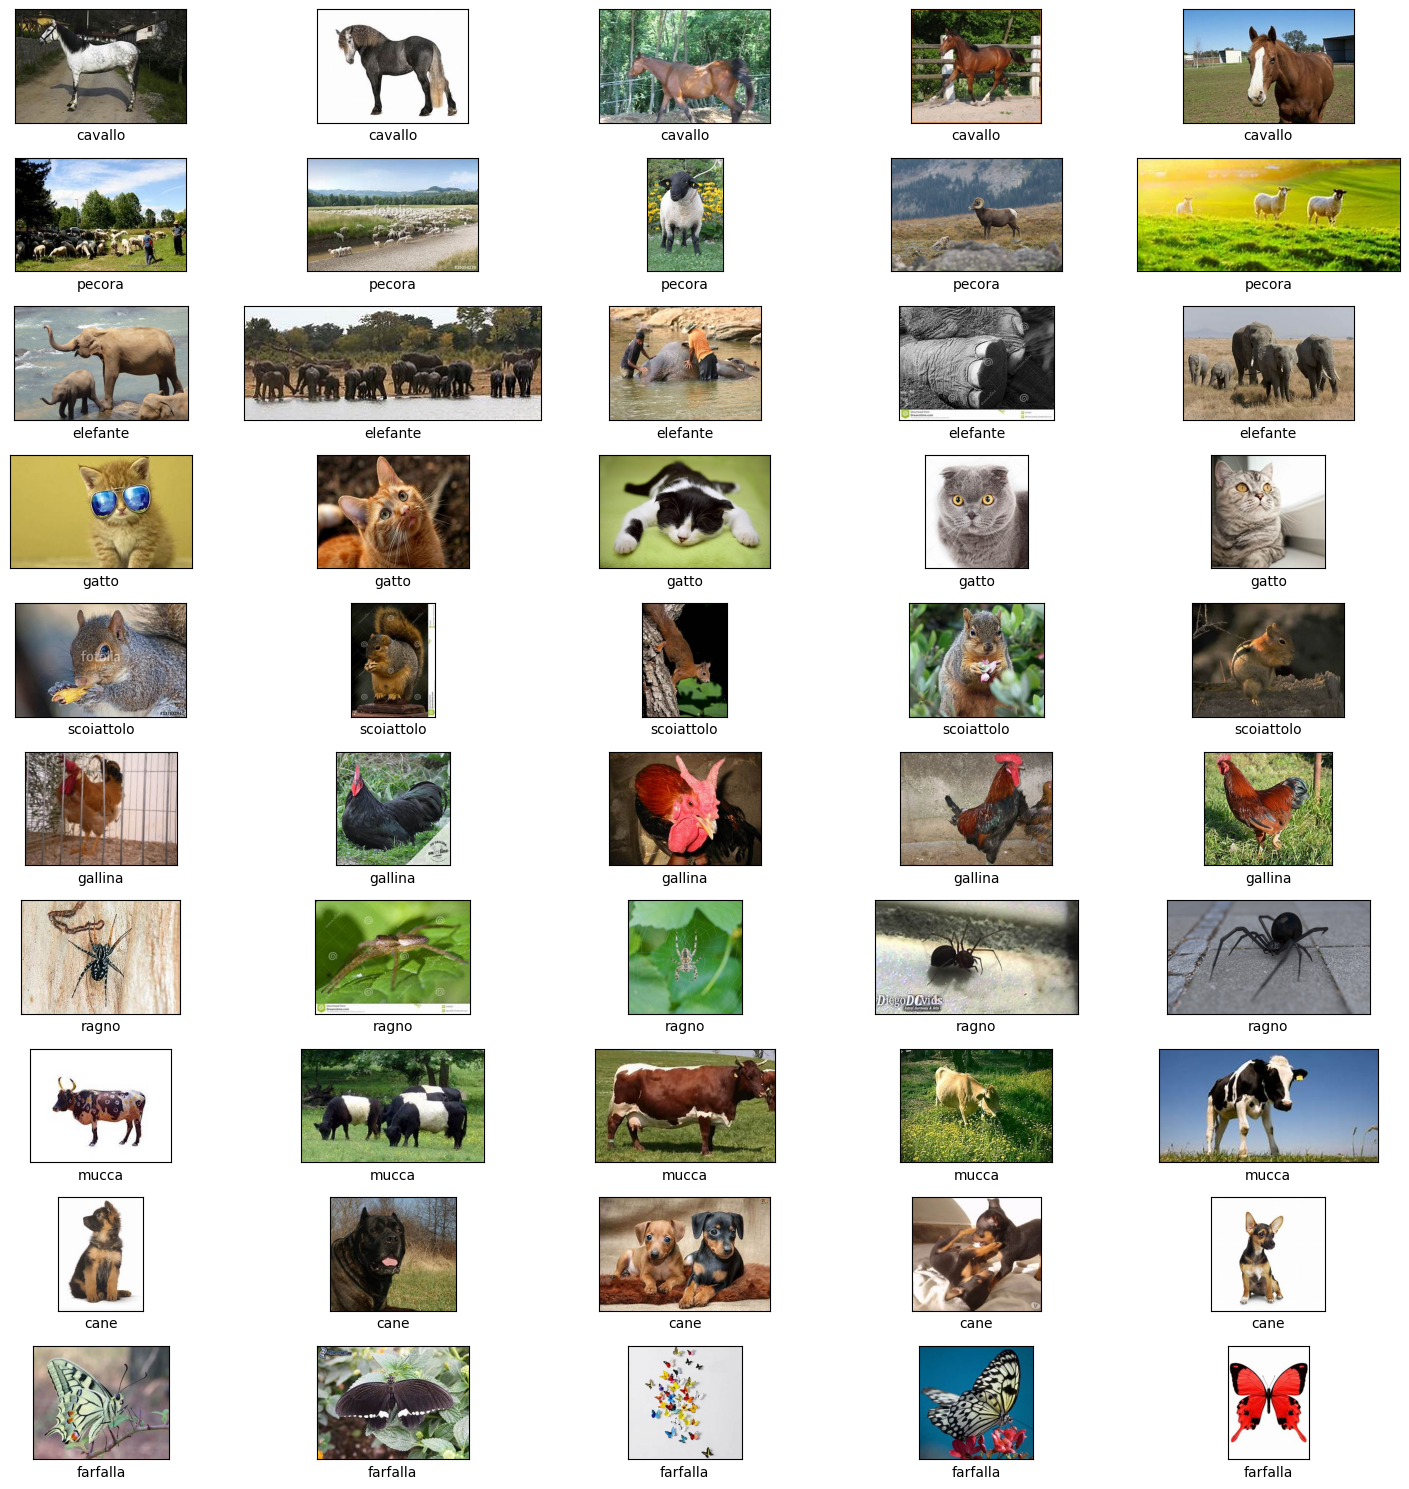

In [5]:
# Show 5 images randomly from each class
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(dataset_path)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(dataset_path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

In [6]:
def process_image(file_path):
    try:
        with Image.open(file_path) as img:
            return img.size
    except Exception as e:
        print(f'Error processing {file_path}: {e}')
            
def get_df(data_path):
    dataset = []
    
    for root, dirs, files in os.walk(data_path):
        for file in files:
            file_path = os.path.join(root, file)
            label = root.split('/')[-1]
            width, height = process_image(file_path)
            
            dataset.append({'file_path': file_path, 'label': label, 'width': width, 'height': height})
            
    return pd.DataFrame(dataset)

In [7]:
df = get_df(dataset_path)
df.head()

,file_path,label,width,height
0,../input/animals10/raw-img/cavallo/OIP-mdvOxIW...,cavallo,225,300
1,../input/animals10/raw-img/cavallo/OIP-TPYKs3X...,cavallo,200,300
2,../input/animals10/raw-img/cavallo/OIP-jlVRrok...,cavallo,300,197
3,../input/animals10/raw-img/cavallo/OIP-F4QVZ71...,cavallo,300,169
4,../input/animals10/raw-img/cavallo/OIP-UFtUZnX...,cavallo,300,225


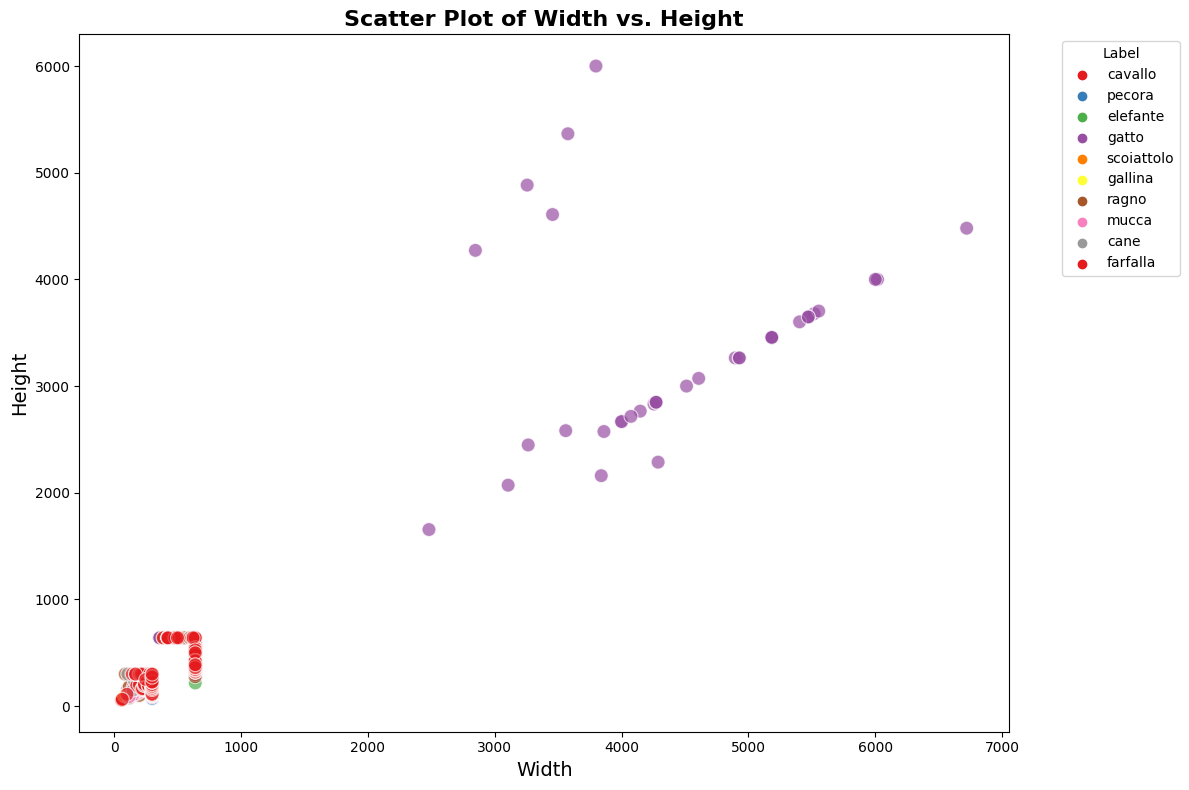

In [8]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='width', y='height', hue='label', palette='Set1', s=100, alpha=0.7)

# Set the axis labels and title
plt.xlabel('Width', fontsize=14)
plt.ylabel('Height', fontsize=14)
plt.title('Scatter Plot of Width vs. Height', fontsize=16, fontweight='bold')

# Add legend outside the plot
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

# <div style="text-align:center; border-radius:25px; padding:20px; color:#3B1AE1; font-size:100%; font-family:cursive; border: 2px solid #00a1d6; overflow: hidden;"><b>🚀 Data Preprocessing</b></div>

In [9]:
target_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


# <div style="text-align:center; border-radius:25px; padding:20px; color:#3B1AE1; font-size:100%; font-family:cursive; border: 2px solid #00a1d6; overflow: hidden;"><b>🚀 Build Model</b></div>

In [10]:
class SaveModel(tf.keras.callbacks.Callback):
    def __init__(self, model_name):
        super(SaveModel, self).__init__()
        self.model_name = model_name
        self.last_val = -float('inf')
        self.best_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        # Check if both accuracy and val_accuracy are above 95%
        if acc >= 0.95 and val_acc >= 0.95:

            # Check if val_accurary improved
            if val_acc > self.last_val:
                self.best_epoch = epoch + 1
                print(f'\nval_accuracy improve from {self.last_val:.4f} to {val_acc:.4f} at epoch {self.best_epoch}, saving model...')
                self.last_val = val_acc
                self.model.save(self.model_name)
            else:
                print(f'\nval_accuracy did not improve, best at epoch {self.best_epoch} with vall_accuracy {self.last_val}')

save_model = SaveModel('best_model.keras')

In [11]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
# Sequential model
model = Sequential()

# Add the base model to Sequential
model.add(base_model)

# Add the custom layers on top of the base model
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))

# Output layer (number of classes)
model.add(Dense(len(classes), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# <div style="text-align:center; border-radius:25px; padding:20px; color:#3B1AE1; font-size:100%; font-family:cursive; border: 2px solid #00a1d6; overflow: hidden;"><b>🚀 Train Model and Evaluation</b></div>

In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=80,            
    epochs=15,
    validation_data=validation_generator,
    validation_steps=80,
    callbacks=[save_model]        
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725760685.970135      85 service.cc:145] XLA service 0x7ddc74026e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725760685.970196      85 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725760685.970202      85 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725760779.504635      85 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 ━━━━━━━━━━━━━━━━━━━━ 192s 473ms/step - accuracy: 0.3602 - loss: 2.5518 - val_accuracy: 0.8430 - val_loss: 0.7199
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 30s 375ms/step - accuracy: 0.7917 - loss: 0.8339 - val_accuracy: 0.9227 - val_loss: 0.4376
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.8707 - loss: 0.5966 - val_accuracy: 0.9732 - val_loss: 0.2752
Epoch 4/15


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 367ms/step - accuracy: 0.8988 - loss: 0.5262 - val_accuracy: 0.9465 - val_loss: 0.3570
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 367ms/step - accuracy: 0.9431 - loss: 0.3871 - val_accuracy: 0.9520 - val_loss: 0.3420
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 297ms/step - accuracy: 0.9308 - loss: 0.4117 - val_accuracy: 0.9375 - val_loss: 0.3869
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 368ms/step - accuracy: 0.9383 - loss: 0.4062 - val_accuracy: 0.9652 - val_loss: 0.2792
Epoch 8/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 29s 367ms/step - accuracy: 0.9510 - loss: 0.3517 - val_accuracy: 0.9500 - val_loss: 0.3310
Epoch 9/15
15/80 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - accuracy: 0.9693 - loss: 0.3252
val_accuracy improve from -inf to 0.9554 at epoch 9, saving model...
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.9672 - loss: 0.3067 - val_accuracy: 0.9554 - val_loss: 0.2911
Epoch 10/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9574 - loss: 0.3411
val_acc

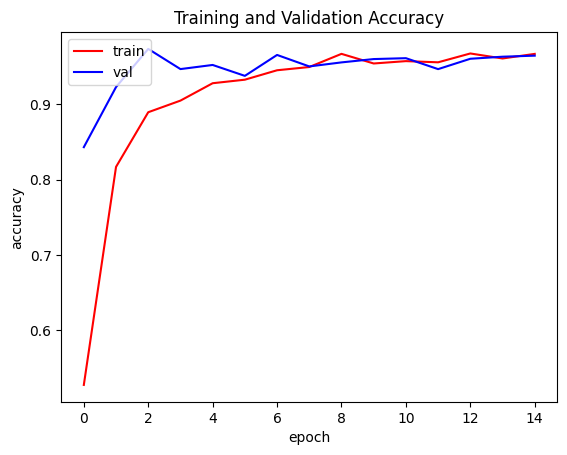

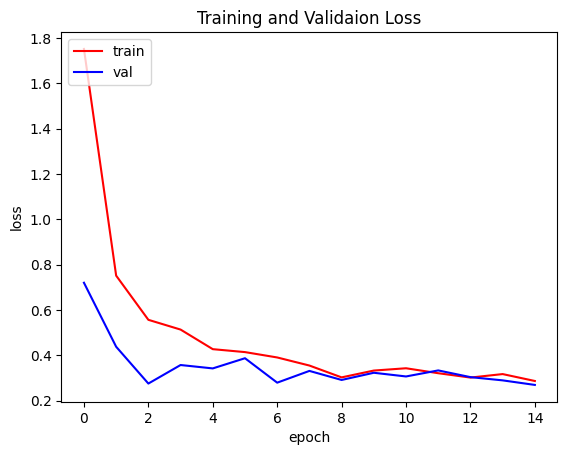

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [14]:
loss_val, acc_val = model.evaluate(validation_generator)

loss_val = "{:.2f}".format(loss_val * 100)
acc_val = "{:.2f}".format(acc_val * 100)

print(f'Valid Loss: {loss_val}%')
print(f'Valid Accuracy: {acc_val}%')

164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.9624 - loss: 0.2862
Valid Loss: 28.73%
Valid Accuracy: 96.44%


In [15]:
preds = model.predict(validation_generator)
y_pred = np.argmax(preds, axis=1)

164/164 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step


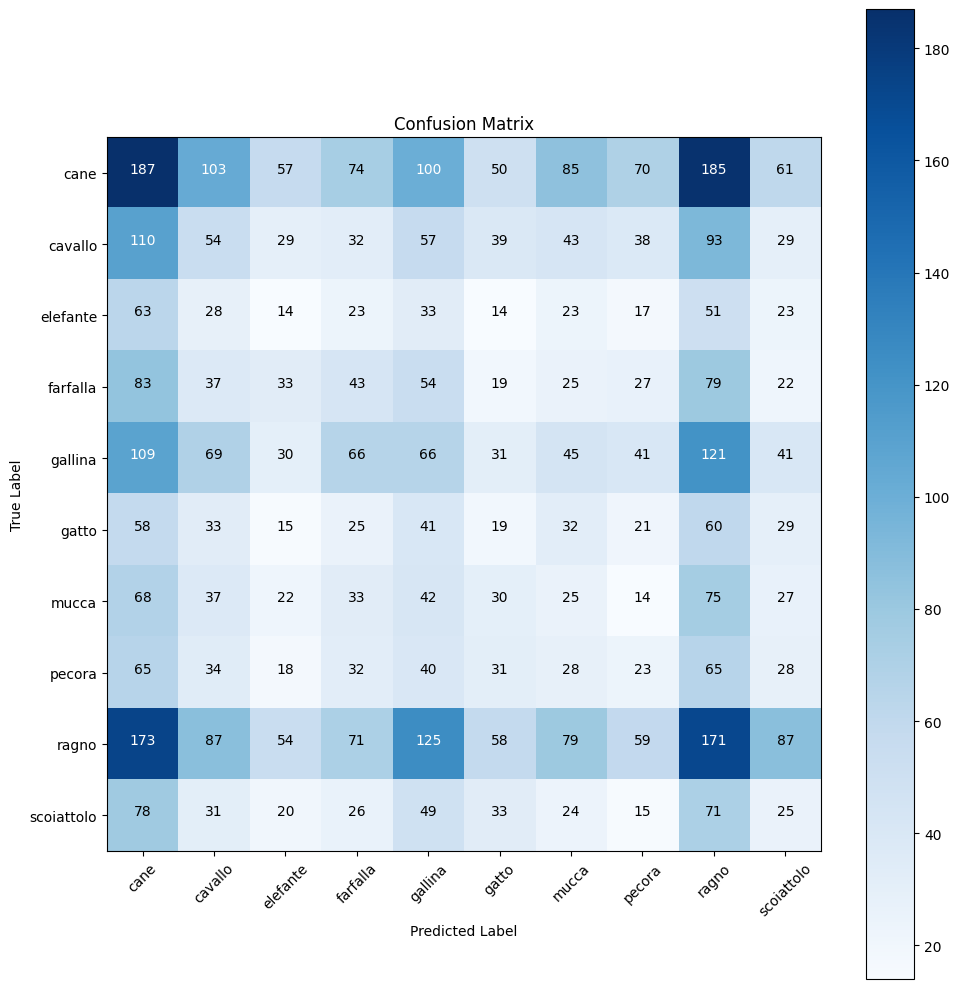

In [16]:
g_dict = validation_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(validation_generator.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [17]:
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    imgplot = plt.imshow(img)

    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)
    predicted_class = classes[np.argmax(prediction)]

    return predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


'gallina'

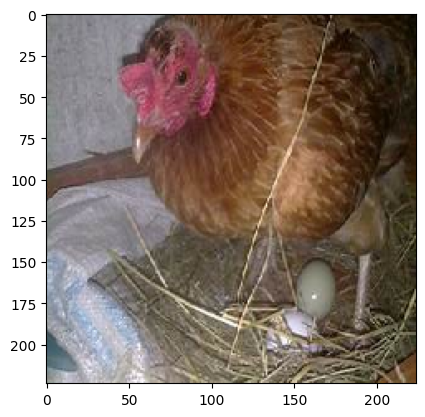

In [18]:
predict_image(model, '/kaggle/input/animals10/raw-img/gallina/1000.jpeg')

# <div style="text-align:center; border-radius:25px; padding:20px; color:#3B1AE1; font-size:100%; font-family:cursive; border: 2px solid #00a1d6; overflow: hidden;"><b>🚀 Save Model</b></div>

In [1]:
%pip install tensorflow==2.15.0 -q

import tensorflow as tf
import os
print(tf.__version__)

Note: you may need to restart the kernel to use updated packages.

2.15.0


In [3]:
submission_dir = 'submission'
os.makedirs(submission_dir, exist_ok=True)

tfjs_dir = os.path.join(submission_dir, 'tfjs_model')
tflite_dir = os.path.join(submission_dir, 'tflite')
saved_model_dir = os.path.join(submission_dir, 'saved_model')

os.makedirs(tfjs_dir, exist_ok=True)
os.makedirs(tflite_dir, exist_ok=True)
os.makedirs(saved_model_dir, exist_ok=True)

In [20]:
model.load_weights('/kaggle/working/best_model.keras')

In [21]:
tf.saved_model.save(model, saved_model_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(os.path.join(tflite_model_dir, 'model.tflite'), 'wb') as file_path:
    file_path.write(tflite_model)

In [22]:
!pip install tensorflowjs -q tensorflow-decision-forests==1.8.1 tensorflow==2.15.0

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.2 requires cubinlinker, which is not installed.
cudf 24.8.2 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.2 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.8.2 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.2 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.6.0 which is incompatible.
distributed 2024.7.1 requires dask==2024.7.1, but you have dask 2024.8.1 which is incompatible.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 23.2 which is incompatible.
jupyterlab 4.2.4 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which 

In [23]:
!tensorflowjs_converter --input_format=tf_saved_model /kaggle/working/submission/saved_model /kaggle/working/submission/tfjs_model

2024-09-08 02:11:06.543706: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 02:11:06.543800: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 02:11:06.545578: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# <div style="text-align:center; border-radius:25px; padding:20px; color:#3B1AE1; font-size:100%; font-family:cursive; border: 2px solid #00a1d6; overflow: hidden;"><b>🚀 Inference</b></div>

Hasil pelatihan model diintegrasikan pada Web Browser menggunakan Tensorflow.js. Gambar di bawah merupakan hasil prediksi dengan input gambar dan urutan label prediksi berdasarkan nilai probabilitasnya.

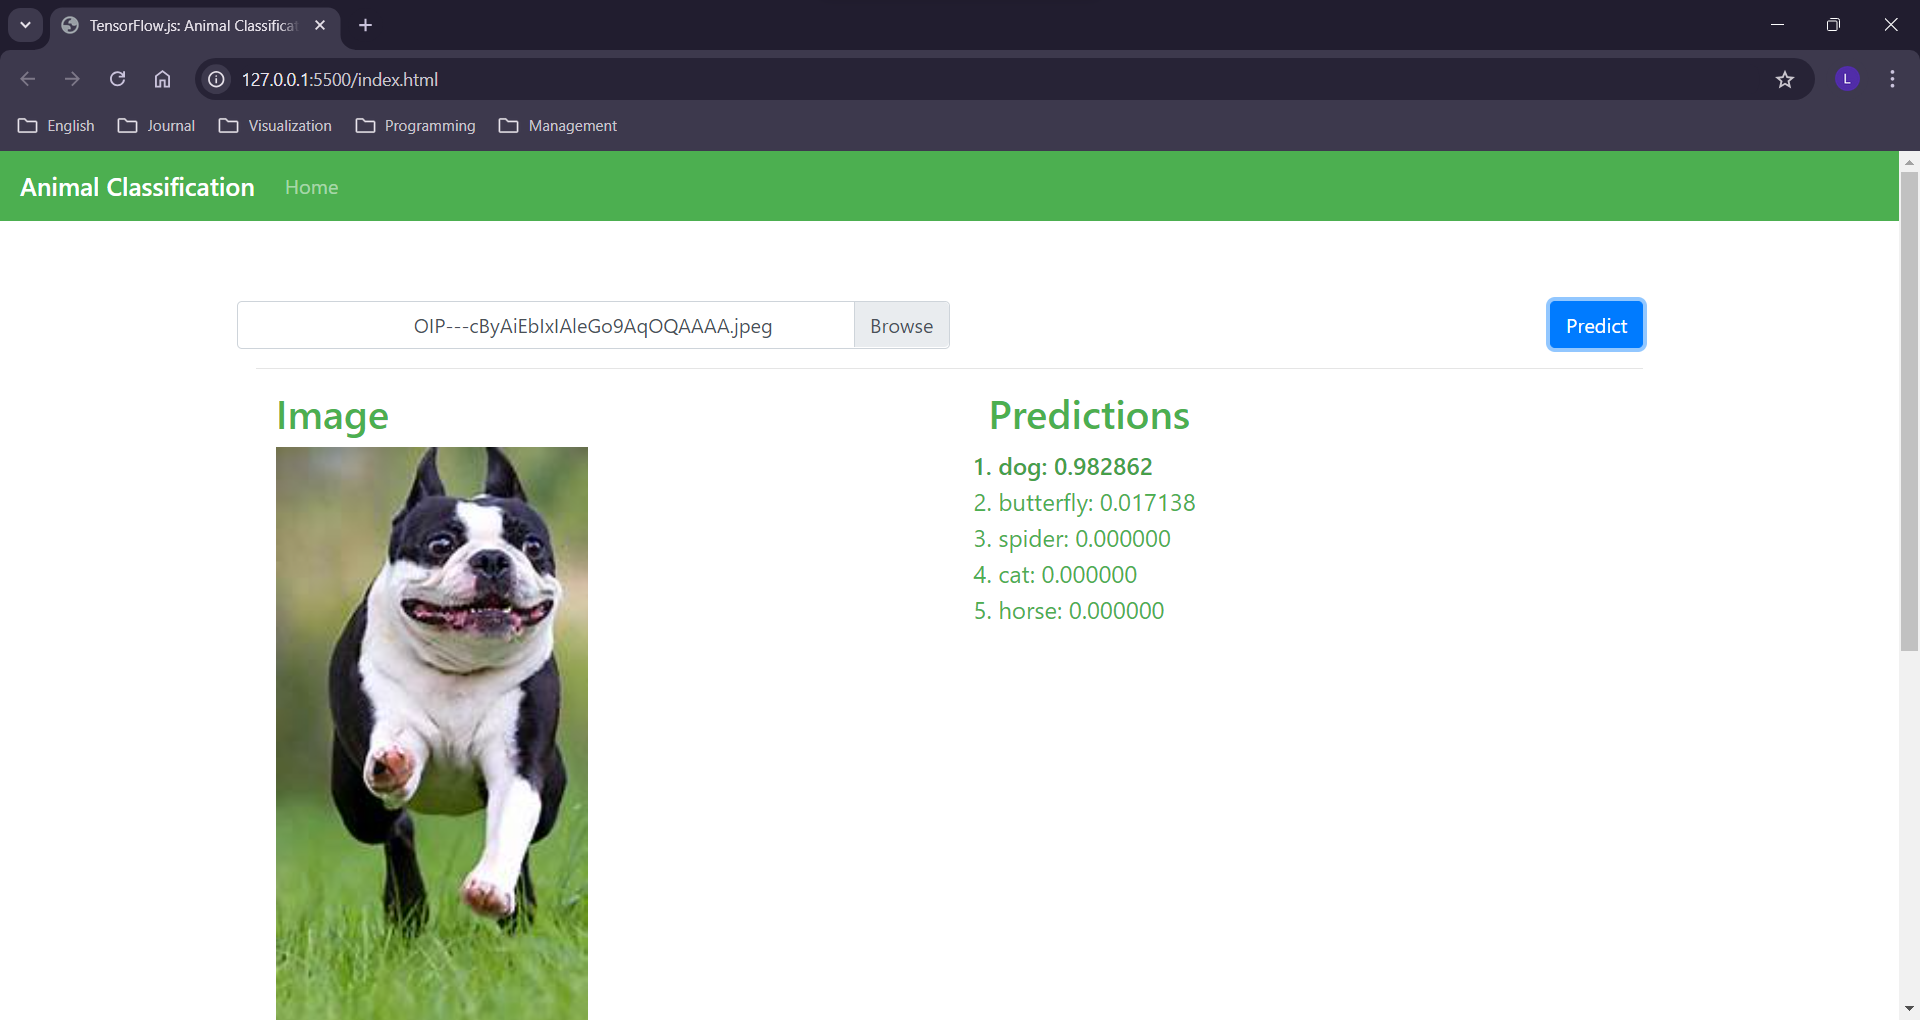